# Transformer For Variable Length Sequences


In [1]:
import utils
from ts2vec import datautils

In [2]:
DATA_PATH = './data'
TB_DATASET = 'UserBehaviorSample.csv'

## 1. 集成到 utils.py

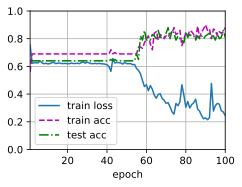

In [3]:
# 分割训练集和验证集
X_train, y_train, X_test, y_test = datautils.load_UCR('ECG200')

tst = utils.TSTransformer(input_dim=None,
                          model_dim=8,
                          nhead=4,
                          num_layers=2,
                          hidden_dim=32,
                          num_classes=2,
                          num_epochs=100,
                          batch_size=25)
predict, metrics = tst(X_train, y_train, X_test, y_test)

In [4]:
print(f'Top 5 predict labels: {predict[:5]}')

for k, v in metrics.items():
    print(f'{k}: {v:.4f}')

Top 5 predict labels: [1, 1, 0, 1, 1]
train_loss: 0.2454
train_acc: 0.8800
test_acc: 0.8100


## 2. 不定长序列

导入淘宝用户行为数据：[TianChi](https://tianchi.aliyun.com/dataset/649) | [Kaggle](https://www.kaggle.com/datasets/marwa80/userbehavior)

字段含义如下：

|Field|Explanation|
| -- | -- |
|User ID|An integer, the serialized ID that represents a user|
|Item ID|An integer, the serialized ID that represents an item|
|Category ID|An integer, the serialized ID that represents the category which the corresponding item belongs to|
|Behavior type|A string, enum-type from ('pv', 'buy', 'cart', 'fav')|
|Timestamp|An integer, the timestamp of the behavior|

In [3]:
csv_path = utils.gen_abspath(DATA_PATH, TB_DATASET)
df = utils.read_csv(csv_path, header=None)
df.columns = ['User ID', 'Item ID', 'Category ID', 'Behavior type', 'Timestamp']
df

,User ID,Item ID,Category ID,Behavior type,Timestamp
0,1,2268318,2520377,pv,1511544070
1,1,2333346,2520771,pv,1511561733
2,1,2576651,149192,pv,1511572885
3,1,3830808,4181361,pv,1511593493
4,1,4365585,2520377,pv,1511596146
...,...,...,...,...,...
9996,1000436,1542569,3619575,buy,1512184723
9997,1000436,2279117,405755,pv,1512184785
9998,1000436,3249912,2920476,pv,1512184868
9999,1000436,921462,1888306,fav,1512184965


对数据进行 reshape 操作，将数据做成 `(样本量, 步长, 特征数)` 的形状

In [6]:
# 先将 Behavior type 编码成数字
behavior_type = df['Behavior type']
cv = utils.Convert(behavior_type)
df['Behavior type'] = df['Behavior type'].apply(cv.encoder)
# df